# Pose analysis panels for longtogeny males

In [1]:
import cv2
import h5py
import umap
import random
import warnings
import numpy as np
import colorcet as cc
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from aging.size_norm.data import clean
from toolz import valmap, compose, groupby, curry, concat, keyfilter
from aging.organization.dataframes import get_age
from aging.size_norm.util import subsample, flatten
from aging.organization.paths import get_experiment_results_by_extraction_time
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend

warnings.simplefilter('ignore')

In [2]:
ONTOGENY_AGE_CMAP = "cubehelix"

In [3]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "supp-fig4", tight_layout=False, dpi=600)

In [4]:
def smooth_clean(frame):
    frame = clean(frame, height_thresh=13)
    frame = cv2.GaussianBlur(frame, (21, 21), 1.5, 1)
    return frame

In [5]:
thinning = 5

In [6]:
def fit_pca(frames: dict[int, np.ndarray], is_recon=False):
    train = subsample(frames, subset=300, seed=0)
    if not is_recon:
        train = np.array(list(map(smooth_clean, train)))
    pca = PCA(n_components=10).fit(flatten(train))
    return pca


def apply_pca_factory(pca):
    return curry(valmap)(compose(pca.transform, flatten))

In [7]:
files = get_experiment_results_by_extraction_time(old=False)

In [8]:
list(files)

['ontogeny_females',
 'ontogeny_males',
 'dana_ontogeny_males',
 'dana_ontogeny_dana_ontogeny',
 'dana_ontogeny_females',
 'longtogeny_males',
 'longtogeny_v2_males',
 'longtogeny_v2_females',
 'wheel',
 'dlight',
 'jax_longtogeny',
 'klothos']

In [9]:
female_files = groupby(lambda x: (get_age(x) // 4) * 4, files["longtogeny_males"])
# don't use the really old animals in this plot - confusing since we don't present the really old animals
female_files = keyfilter(lambda k: k < 80, female_files)

In [10]:
def load_frames(key, n_frames, path):
    with h5py.File(path, 'r') as h5f:
        return h5f[key][:n_frames]


def select_files(n_files: int, files: list):
    files = deepcopy(files)
    random.shuffle(files)
    return files[:n_files]

In [11]:
# select and load a subset of frames from a subset of files
n_files = 10
frames_per_file = 3_500

In [12]:
frame_loader = curry(load_frames)("frames", frames_per_file)
recon_frame_loader = curry(load_frames)("win_size_norm_frames_v7", frames_per_file)
file_selector = curry(select_files)(n_files)

file_aggregator = curry(map)(frame_loader)
recon_file_aggregator = curry(map)(recon_frame_loader)

In [13]:
random.seed(1)
frames_files = valmap(compose(list, file_selector), female_files)

In [14]:
frames_dict = valmap(compose(np.vstack, list, file_aggregator), frames_files)
recon_frames_dict = valmap(compose(np.vstack, list, recon_file_aggregator), frames_files)

In [15]:
pca = fit_pca(frames_dict, is_recon=False)
apply_pca = apply_pca_factory(pca)
og_frame_pcs = apply_pca(frames_dict)

In [16]:
recon_pca = fit_pca(recon_frames_dict, is_recon=True)
apply_pca = apply_pca_factory(recon_pca)
recon_frame_pcs = apply_pca(recon_frames_dict)

## Plot pca pre- and post-

In [17]:
_pcs = np.vstack(list(og_frame_pcs.values()))
ages = np.array(list(concat([k] * len(v) for k, v in og_frame_pcs.items())))

In [18]:
permutation = np.random.permutation(len(_pcs))[::thinning]

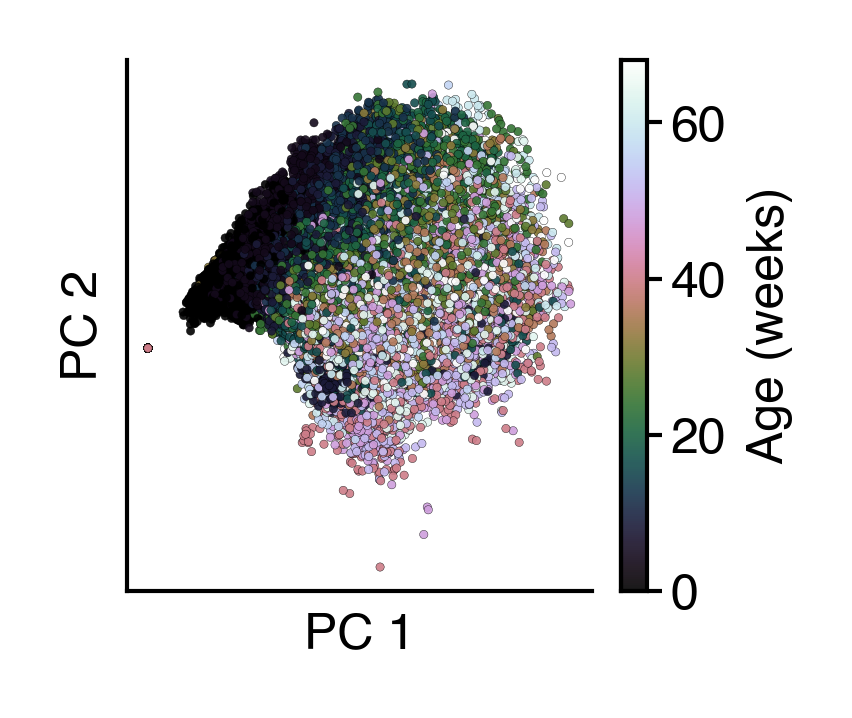

In [19]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *_pcs[permutation, :2].T,
    c=ages[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=0,
    # vmax=100,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, 'pre-model-pcs-across-age', dpi=700);

In [20]:
_pcs = np.vstack(list(recon_frame_pcs.values()))
ages = np.array(list(concat([k] * len(v) for k, v in recon_frame_pcs.items())))

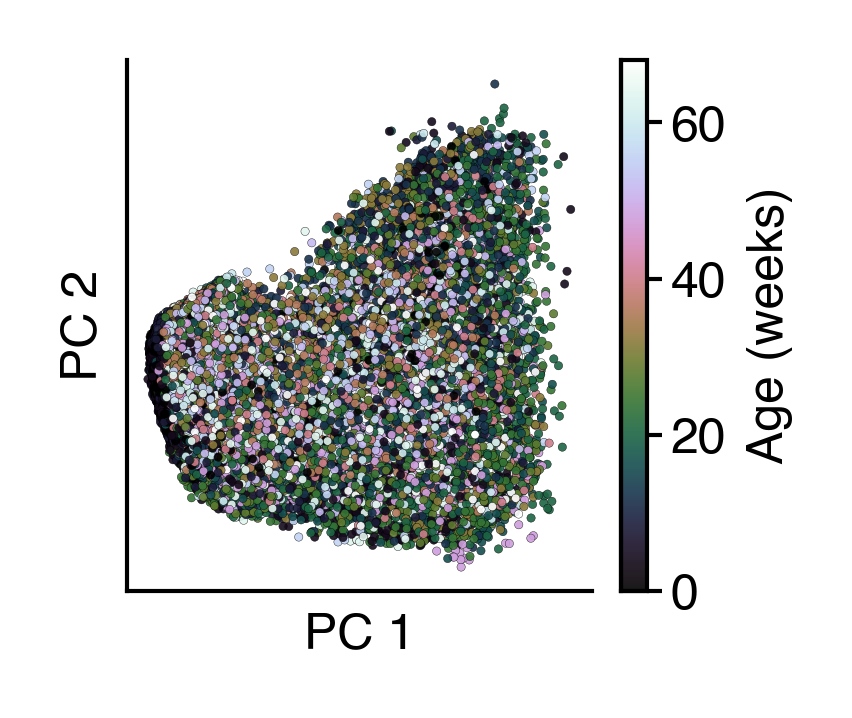

In [21]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *_pcs[permutation, :2].T,
    c=ages[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=0,
    # vmax=100,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, 'post-model-pcs-across-age', dpi=700);

## Plot UMAP pre- and post-

In [22]:
_pcs = np.vstack(list(og_frame_pcs.values()))
ages = np.array(list(concat([k] * len(v) for k, v in og_frame_pcs.items())))

umap_mdl = umap.UMAP(random_state=0)
pre_latents = umap_mdl.fit_transform(_pcs[permutation])

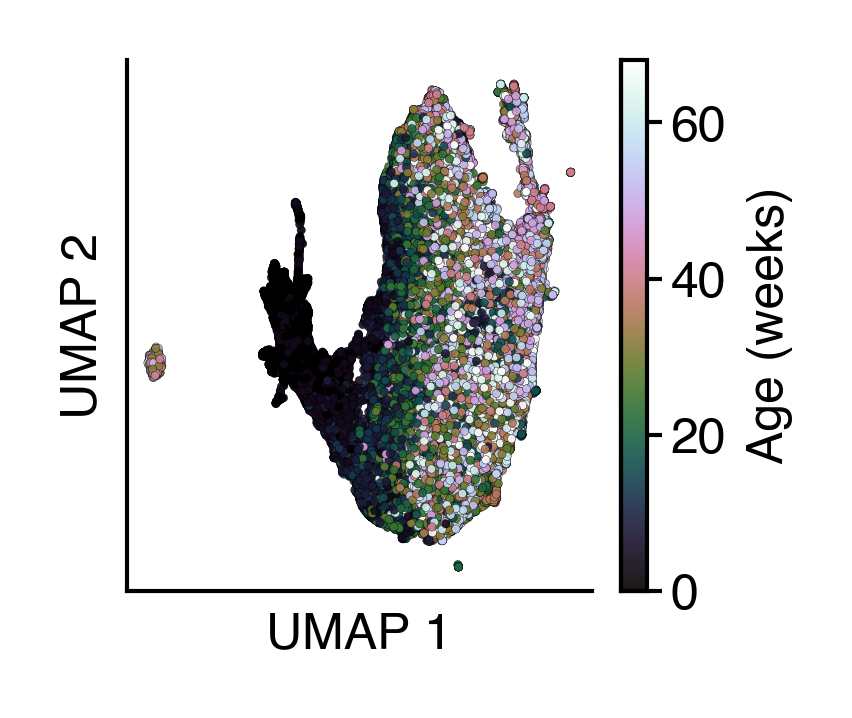

In [23]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *pre_latents.T,
    c=ages[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=0,
    # vmax=100,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, 'pre-model-umap-across-age', dpi=700);

In [ ]:
_pcs = np.vstack(list(recon_frame_pcs.values()))
ages = np.array(list(concat([k] * len(v) for k, v in recon_frame_pcs.items())))

umap_mdl = umap.UMAP(random_state=0)
post_latents = umap_mdl.fit_transform(_pcs[permutation])

In [ ]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *post_latents.T,
    c=ages[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=0,
    # vmax=100,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, 'post-model-umap-across-age', dpi=700);

## k-means clustering of post-NN space, apply coloring to pre-NN space

In [ ]:
from sklearn.cluster import k_means

In [ ]:
def get_avg_frames(labels, frames):
    np.random.seed(0)
    avgs = {}
    counts = {}
    start = 0
    unique_labels = np.unique(labels)
    for k, v in frames.items():
        label_subset = labels[start:start+len(v)]
        start += len(v)
        for i in unique_labels:
            if i not in avgs:
                avgs[i] = np.sum(v[label_subset == i], axis=0)
                counts[i] = np.sum(label_subset == i)
            else:
                avgs[i] = avgs[i] + np.sum(v[label_subset == i], axis=0)
                counts[i] = counts[i] + np.sum(label_subset == i)
    return {k: v / counts[k] for k, v in avgs.items()}

In [ ]:
_pcs = np.vstack(list(recon_frame_pcs.values()))
ages = np.array(list(concat([k] * len(v) for k, v in recon_frame_pcs.items())))

centroid, labels, inertia = k_means(
    _pcs, n_clusters=5, random_state=0
)

In [ ]:
recon_frame_clusters = get_avg_frames(labels, recon_frames_dict)
frame_clusters = get_avg_frames(labels, frames_dict)

In [ ]:
for k, v in frame_clusters.items():
    fig = figure(0.5, 0.5)
    ax = fig.gca()
    im = ax.imshow(v, vmax=80, cmap=ONTOGENY_AGE_CMAP, vmin=0)
    ax.set(xticks=[], yticks=[])
    fig.colorbar(im, ax=ax, label="Height (mm)")
    plt.title(k)
    saver(fig, f"avg-cluster-{k}-pre-pose-post-fit-to-pre");

In [ ]:
for k, v in recon_frame_clusters.items():
    fig = figure(0.5, 0.5)
    ax = fig.gca()
    im = ax.imshow(v, vmax=80, cmap=ONTOGENY_AGE_CMAP, vmin=0)
    ax.set(xticks=[], yticks=[])
    fig.colorbar(im, ax=ax, label="Height (mm)")
    plt.title(k)
    saver(fig, f"avg-cluster-{k}-post-pose-post-fit-to-pre");

In [ ]:
centroid.shape

In [ ]:
pre_centroids = {k: np.mean(pre_latents[labels[permutation] == k], axis=0) for k in sorted(np.unique(labels))}
pre_centroids = np.array(list(pre_centroids.values()))

post_centroids = {k: np.mean(post_latents[labels[permutation] == k], axis=0) for k in sorted(np.unique(labels))}
post_centroids = np.array(list(post_centroids.values()))

In [ ]:
fig = figure(1.25, 1.15)
ax = fig.gca()
ax.scatter(*post_centroids[:, :2].T, color='k', s=3, zorder=2)
im = ax.scatter(
    *post_latents.T,
    c=labels[permutation],
    cmap=cc.cm.glasbey,
    s=0.4,
    lw=0,
    # ec="k",
    alpha=0.9,
    rasterized=True,
    vmax=256
)
cb = fig.colorbar(im, label="Cluster", ax=ax, boundaries=[0, 1, 2, 3, 4, 5])
cb.set_ticks(np.arange(0.5, 5, 1))
cb.set_ticklabels((np.arange(0.5, 5, 1) + 0.5).astype(int))
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, "post-model-umap-across-pose-clusters-post-fit", dpi=700);

In [ ]:
fig = figure(1.25, 1.15)
ax = fig.gca()
ax.scatter(*pre_centroids[:, :2].T, color='k', s=3, zorder=2)
im = ax.scatter(
    *pre_latents.T,
    c=labels[permutation],
    cmap=cc.cm.glasbey,
    s=0.4,
    lw=0,
    # ec="k",
    alpha=0.9,
    rasterized=True,
    vmax=256
)
cb = fig.colorbar(im, label="Cluster", ax=ax, boundaries=[0, 1, 2, 3, 4, 5])
cb.set_ticks(np.arange(0.5, 5, 1))
cb.set_ticklabels((np.arange(0.5, 5, 1) + 0.5).astype(int))
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, "pre-model-umap-across-pose-clusters-post-fit", dpi=700);

## Area transform

In [ ]:
import polars as pl

In [ ]:
colors = ['#dadaeb', '#6a51a3']
female_cmap = sns.blend_palette(colors, as_cmap=True)

In [ ]:
version = 11
df = pl.scan_parquet(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longtogeny_males_syllable_df_v00.parquet"
)

In [39]:
areas = (
    df.filter(pl.col("age") < 80)
    .with_columns((pl.col("age") // 4) * 4)
    .group_by(["age", "session_name", "uuid"])
    .agg([pl.col("area_px").median(), pl.col("recon_area").median()])
    .group_by("age")
    .agg([pl.col("area_px").mean(), pl.col("recon_area").mean()])
    .filter(pl.col("age") < 100)
    .collect()
)

melted_areas = areas.to_pandas().melt(id_vars='age', value_vars=['area_px', 'recon_area'])

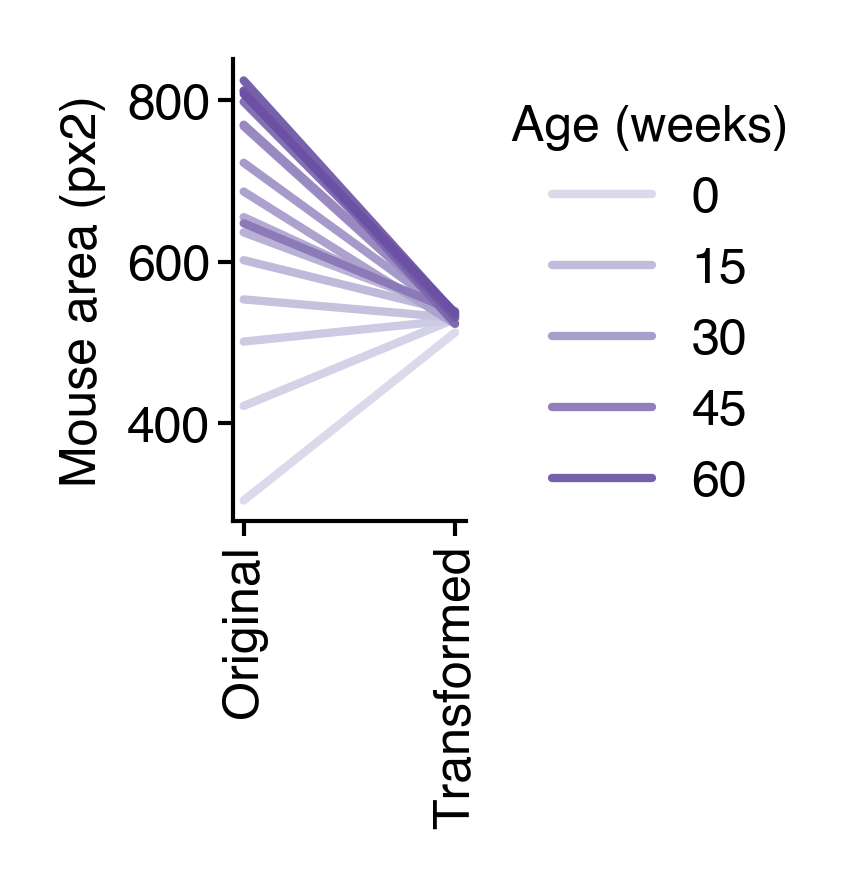

In [40]:
fig = figure(0.5, 1)
ax = sns.lineplot(
    data=melted_areas, x="variable", y="value", hue="age", palette=female_cmap
)
ax.set(ylabel="Mouse area (px2)", xlabel="", xticklabels=["Original", "Transformed"])
plt.xticks(rotation=90)
legend(ax, title="Age (weeks)")
sns.despine()
saver(fig, "intra-age-area-mean");

## Extract dynamics

In [41]:
import pandas as pd
import polars as pl
from aging.behavior.scalars import compute_scalars

In [42]:
dynamics_frame_loader = curry(load_frames)("frames", frames_per_file * 3)
dynamics_recon_frame_loader = curry(load_frames)("win_size_norm_frames_v7", frames_per_file * 3)
dynamics_file_aggregator = curry(map)(dynamics_frame_loader)
dynamics_recon_file_aggregator = curry(map)(dynamics_recon_frame_loader)

In [43]:
frames_dict = valmap(compose(list, dynamics_file_aggregator), frames_files)
recon_frames_dict = valmap(compose(list, dynamics_recon_file_aggregator), frames_files)

In [44]:
rolling_win_size = 40 * 30

dynamics_corr_df = []
dynamics_rolling_corr_df = []

for age, frames_list in tqdm(frames_dict.items()):
    for i, (_og_frames, _recon_frames) in enumerate(
        zip(frames_list, recon_frames_dict[age])
    ):
        scalars = compute_scalars(_og_frames.copy(), is_recon=False, height_thresh=12)
        recon_scalars = compute_scalars(_recon_frames.copy(), is_recon=False, height_thresh=12)

        # aggregate correlations for all scalars
        # alse compute rolling correlations to find plottable examples
        tmp_corrs = {}
        rolling_corrs = {}

        for k, v in scalars.items():
            tmp_corrs[k] = pd.Series(v).corr(pd.Series(recon_scalars[k]))
            pl_df = pl.DataFrame({k: v, f"{k}_recon": recon_scalars[k]})
            corr_val = pl_df.with_columns(
                [
                    pl.rolling_corr(
                        k, f"{k}_recon", window_size=rolling_win_size
                    ).alias("corr")
                ]
            )["corr"]
            rolling_corrs[k] = np.asarray(corr_val)
        tmp_corrs["avg"] = np.mean(list(tmp_corrs.values()))
        tmp_corrs["age"] = age

        dynamics_corr_df.append(tmp_corrs)

        rolling_corrs = pd.DataFrame(rolling_corrs)
        rolling_corrs["avg"] = rolling_corrs.mean(1)
        rolling_corrs["age"] = age
        rolling_corrs["file_index"] = i

        dynamics_rolling_corr_df.append(rolling_corrs)

dynamics_corr_df = pd.DataFrame(dynamics_corr_df)
dynamics_rolling_corr_df = pd.concat(dynamics_rolling_corr_df)

  0%|          | 0/17 [00:00<?, ?it/s]

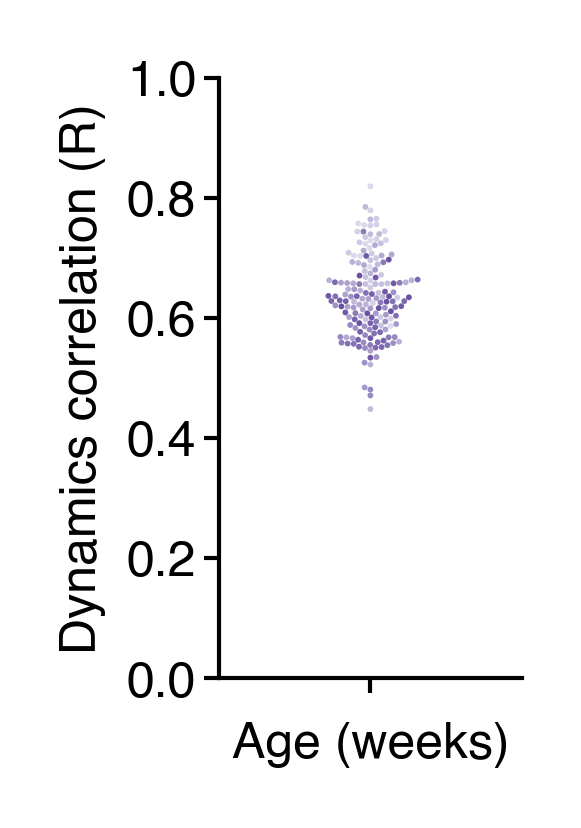

In [45]:
fig = figure(0.65, 1.3)
ax = sns.swarmplot(
    data=dynamics_corr_df,
    y="avg",
    hue="age",
    palette=female_cmap,
    size=0.7,
    legend=False,
)
ax.set(ylim=(0, 1), xlabel="Age (weeks)", ylabel="Dynamics correlation (R)")
sns.despine()
saver(fig, "dynamics-correlation-vs-age-swarmplot");

### Individual examples of dynamics

In [46]:
def zscore(arr):
    return (arr - np.nanmean(arr)) / np.nanstd(arr)

In [47]:
def get_best_example(age):
    best_young_session = (
        dynamics_rolling_corr_df.query("age == @age")
        .groupby("file_index")["width"]
        .max()
        .idxmax()
    )
    end_idx = np.argmax(dynamics_rolling_corr_df.query("age == @age & file_index == @best_young_session")["width"])
    return best_young_session, end_idx

In [48]:
best_young_session, end_idx = get_best_example(4)

In [49]:
data = frames_dict[4][best_young_session]
recon_data = recon_frames_dict[4][best_young_session]

In [50]:
def compute_example(data, recon_data):
    scalars = compute_scalars(data.copy(), is_recon=False, height_thresh=12)
    recon_scalars = compute_scalars(recon_data.copy(), is_recon=False, height_thresh=12)
    start = end_idx - rolling_win_size
    w1 = zscore(scalars["width"][start:end_idx])
    w2 = zscore(recon_scalars["width"][start:end_idx])

    w1 = pd.Series(w1).rolling(8).mean()
    w2 = pd.Series(w2).rolling(8).mean()

    ww1 = scalars['width'][start:end_idx]
    ww2 = recon_scalars['width'][start:end_idx]

    ww1 = pd.Series(ww1).rolling(8).mean()
    ww2 = pd.Series(ww2).rolling(8).mean()

    return w1, w2, ww1, ww2

In [51]:
time = np.arange(rolling_win_size) / 30

In [52]:
w1, w2, ww1, ww2 = compute_example(data, recon_data)

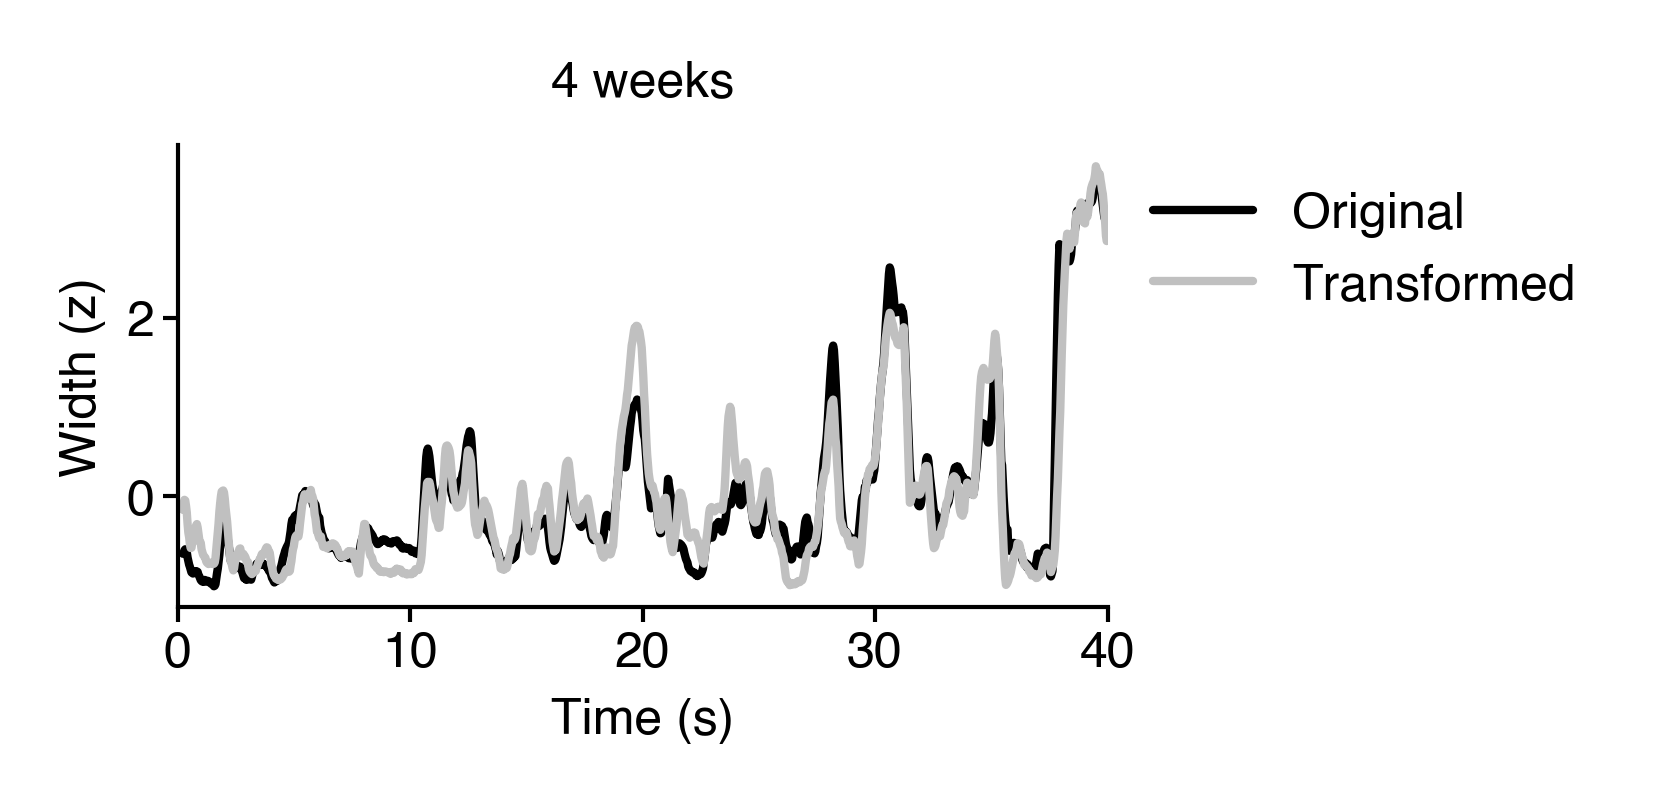

In [53]:
fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, w1, label='Original', color='k')
ax.plot(time, w2, label='Transformed', color='silver')
ax.set(xlabel="Time (s)", ylabel="Width (z)", title='4 weeks', xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, 'dynamics-example-4-wks');

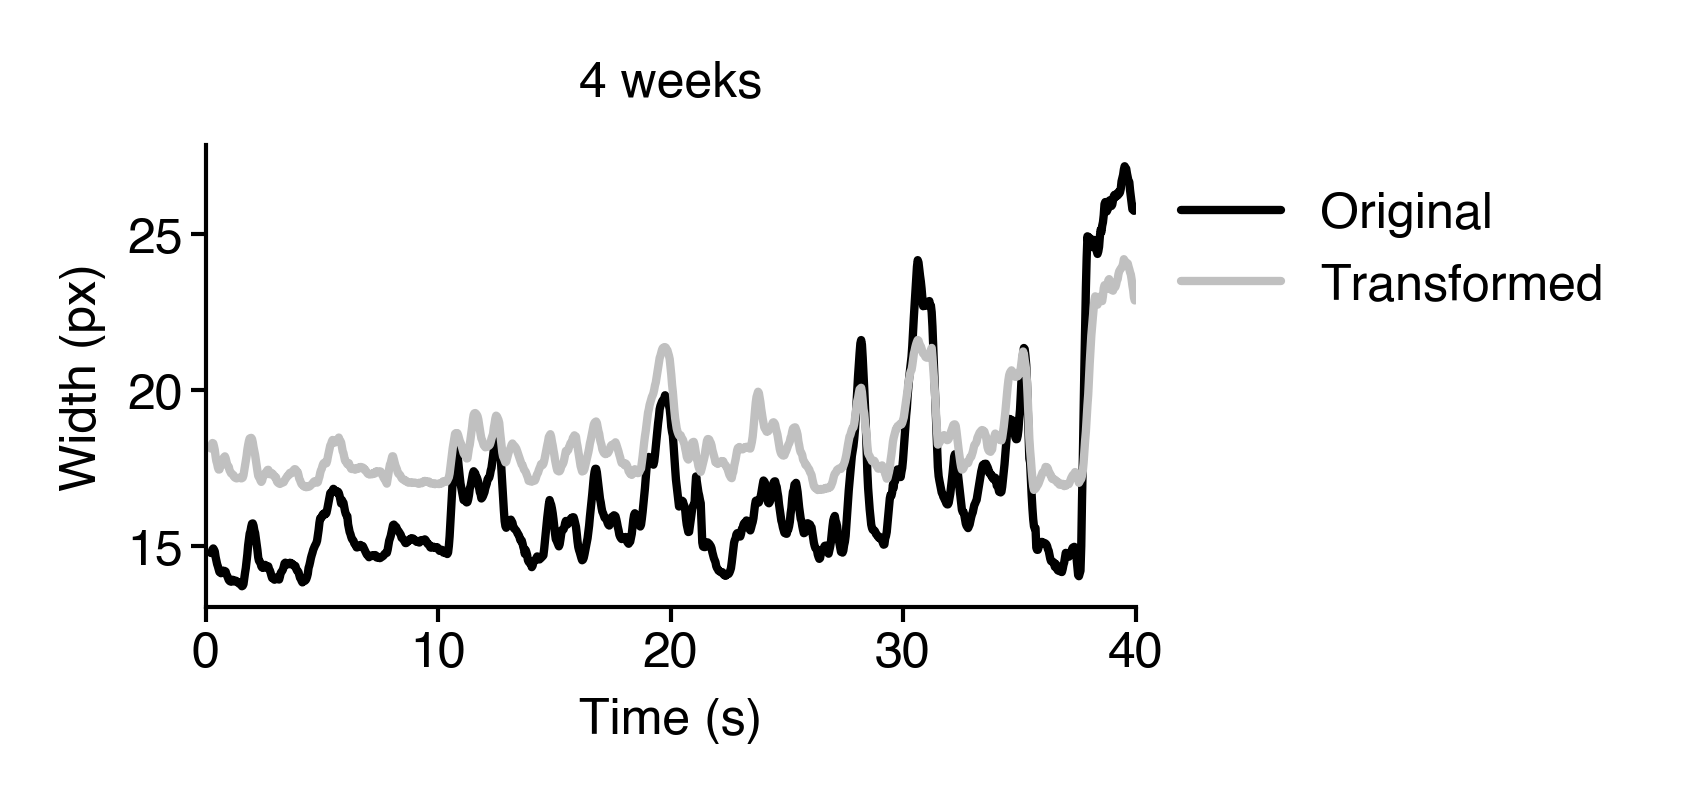

In [54]:
fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, ww1, label='Original', color='k')
ax.plot(time, ww2, label='Transformed', color='silver')
ax.set(xlabel="Time (s)", ylabel="Width (px)", title='4 weeks', xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, 'dynamics-example-raw-4-wks');

In [55]:
best_young_session, end_idx = get_best_example(68)

data = frames_dict[68][best_young_session]
recon_data = recon_frames_dict[68][best_young_session]

In [56]:
w1, w2, ww1, ww2 = compute_example(data, recon_data)

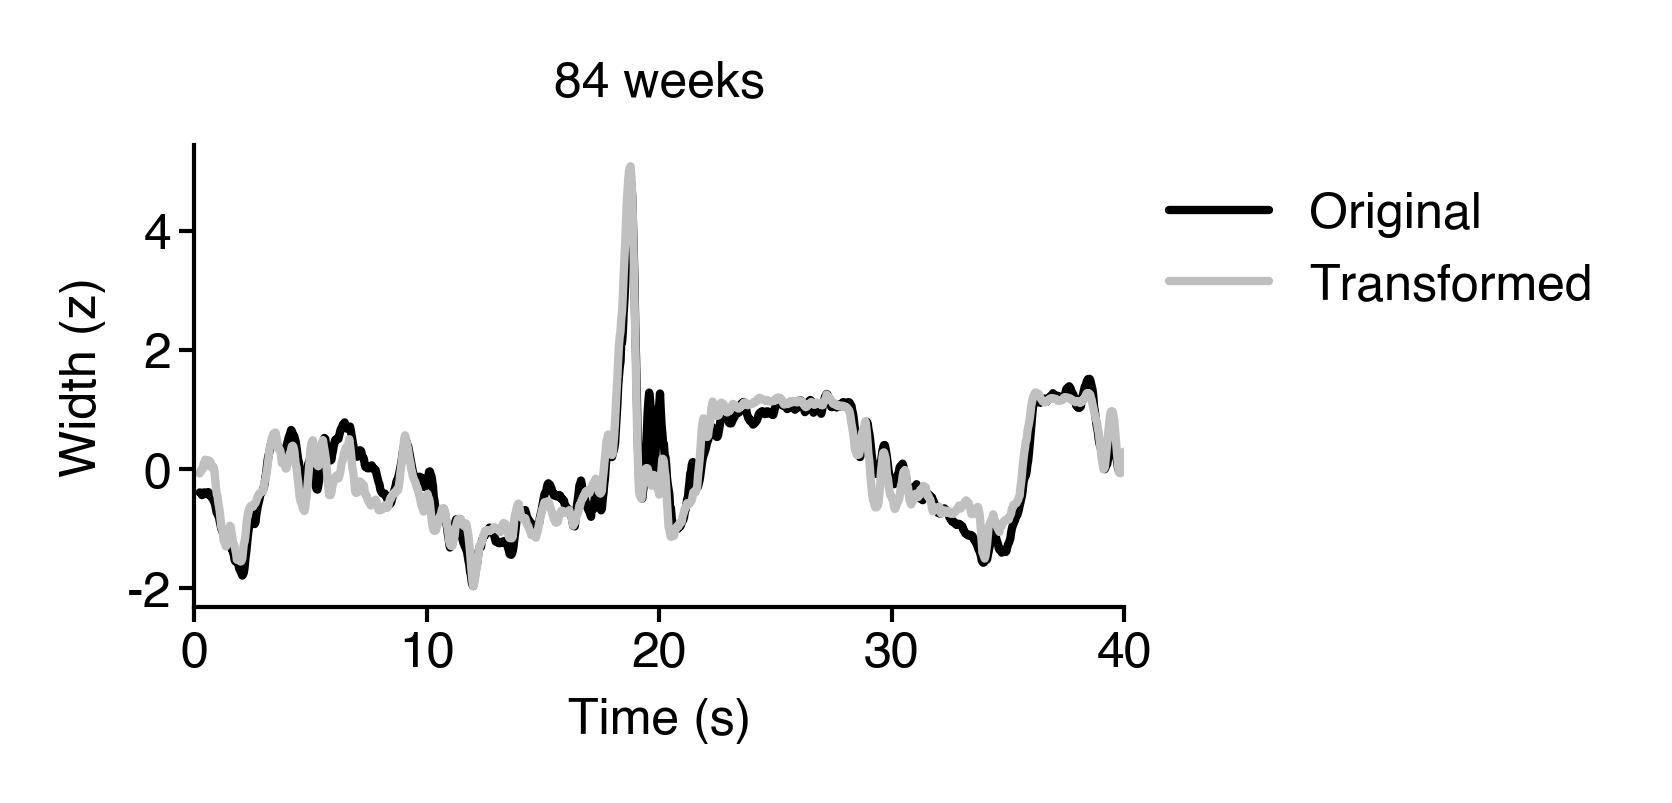

In [57]:
fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, w1, label='Original', color='k')
ax.plot(time, w2, label='Transformed', color='silver')
ax.set(xlabel="Time (s)", ylabel="Width (z)", title='84 weeks', xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, 'dynamics-example-68-wks');

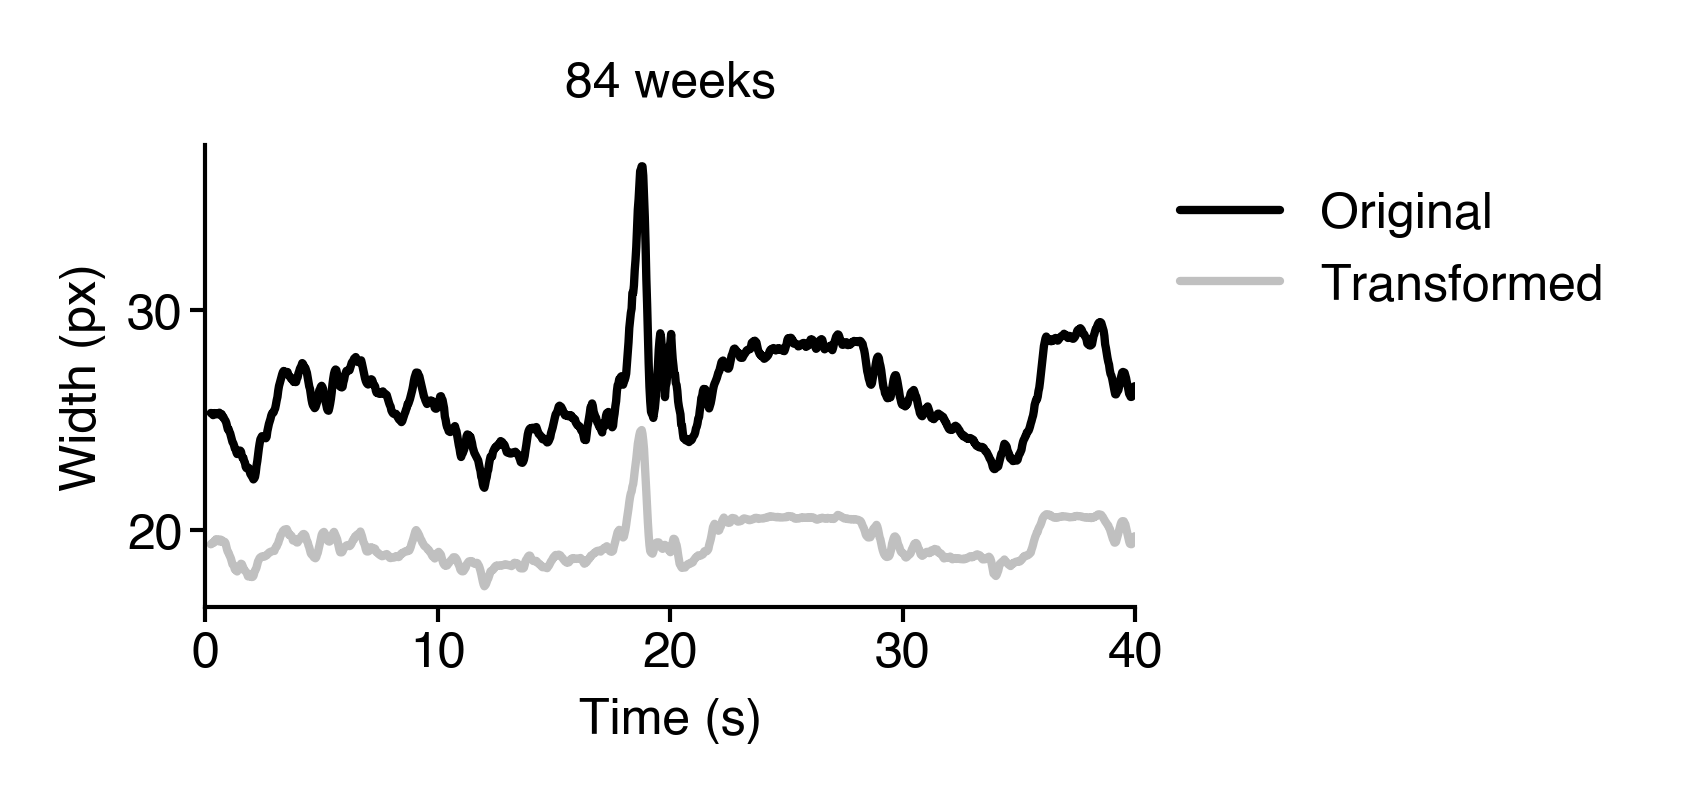

In [58]:
fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, ww1, label='Original', color='k')
ax.plot(time, ww2, label='Transformed', color='silver')
ax.set(xlabel="Time (s)", ylabel="Width (px)", title='84 weeks', xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, 'dynamics-example-raw-68-wks');

In [59]:
best_young_session, end_idx = get_best_example(12)

data = frames_dict[12][best_young_session]
recon_data = recon_frames_dict[12][best_young_session]

w1, w2, ww1, ww2 = compute_example(data, recon_data)

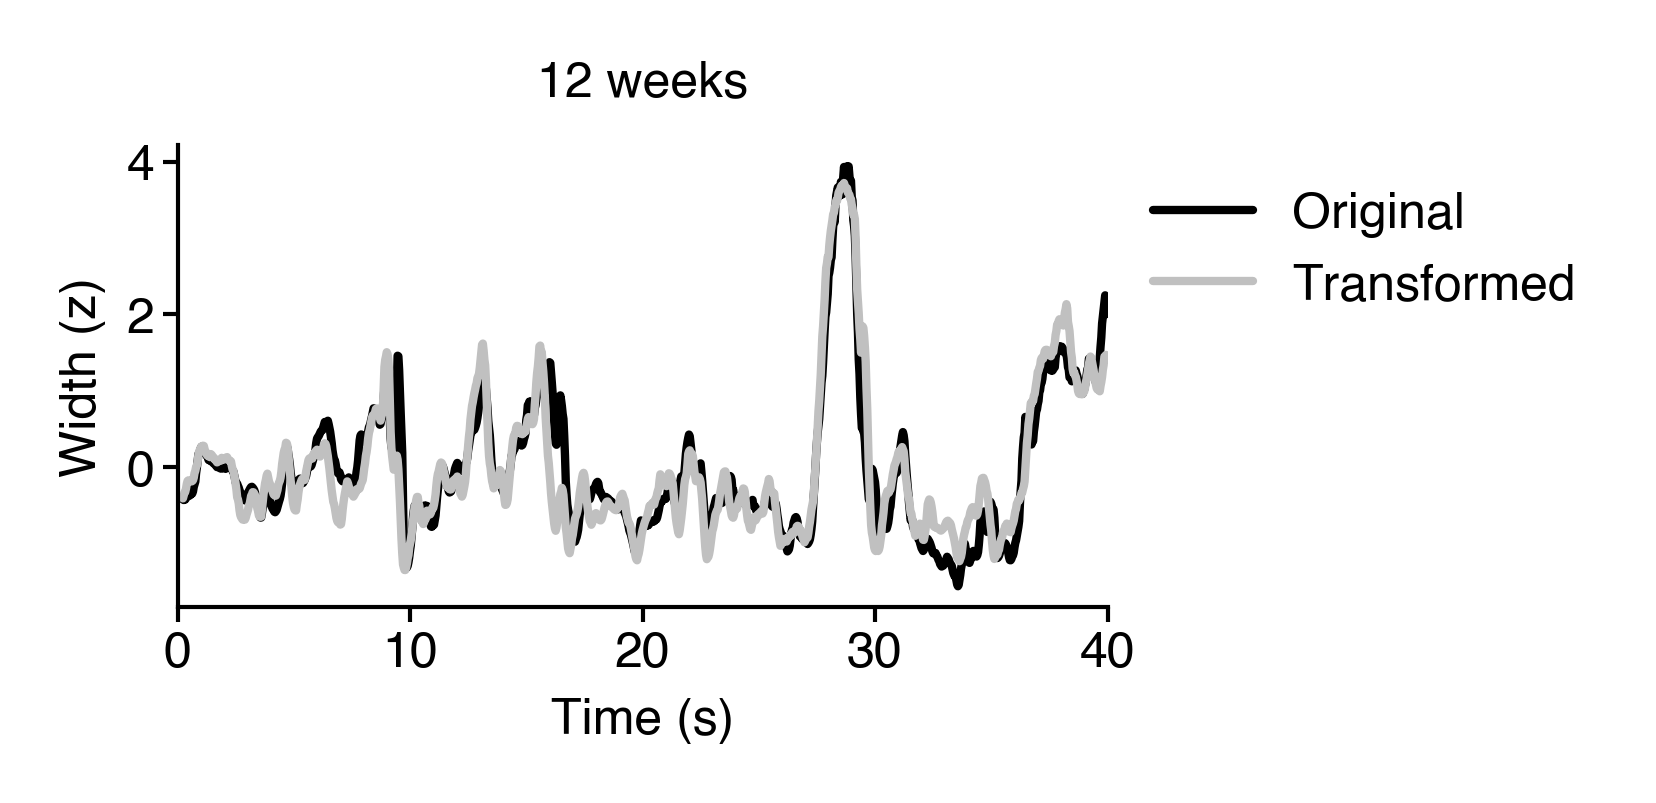

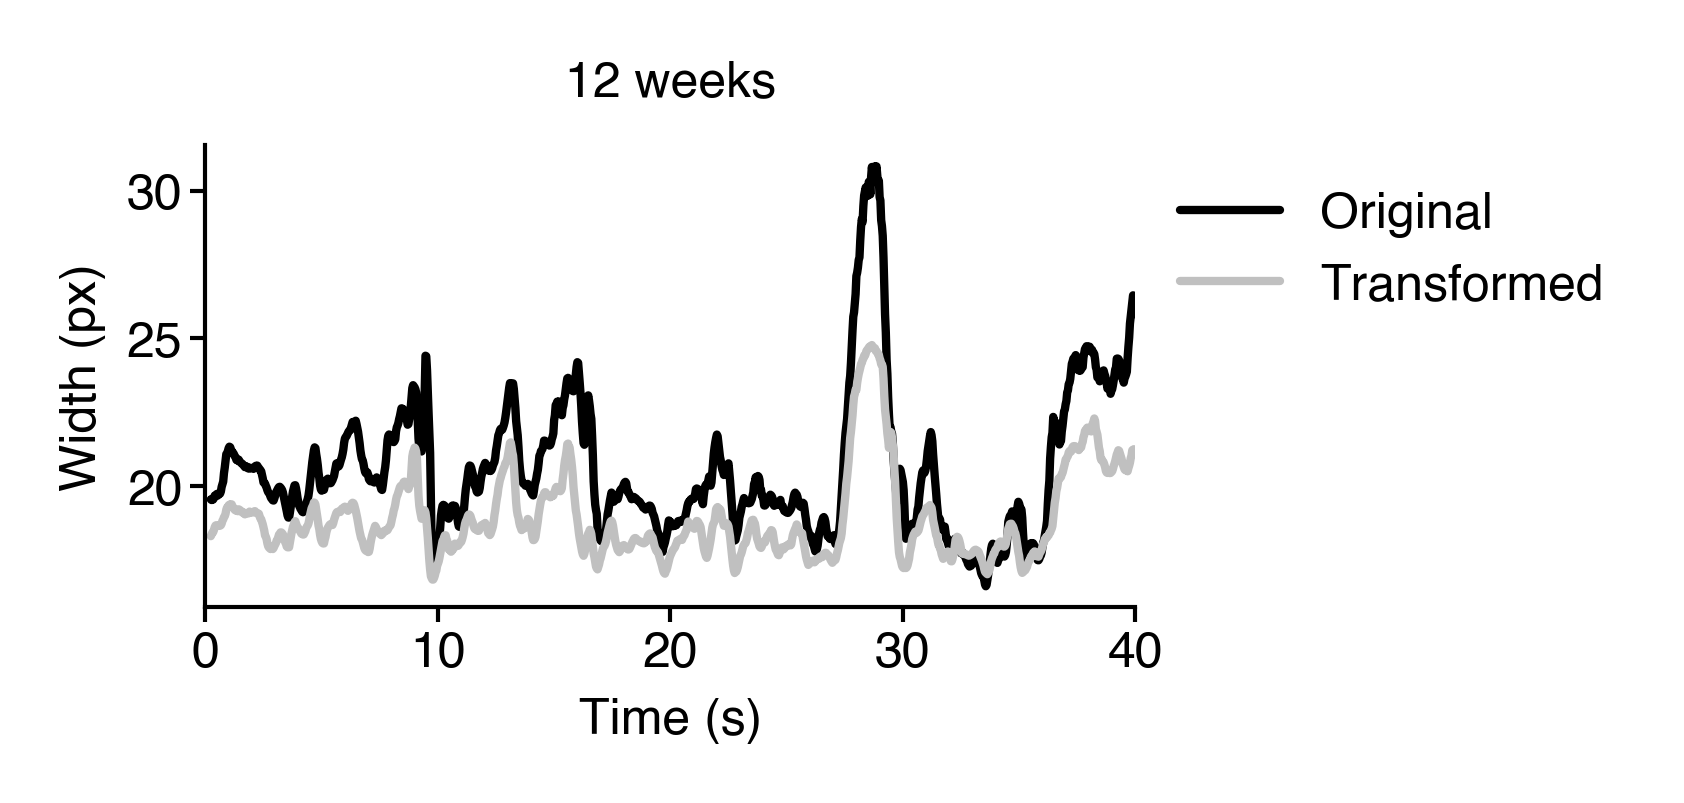

In [60]:
fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, w1, label='Original', color='k')
ax.plot(time, w2, label='Transformed', color='silver')
ax.set(xlabel="Time (s)", ylabel="Width (z)", title='12 weeks', xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, 'dynamics-example-12-wks');

fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, ww1, label='Original', color='k')
ax.plot(time, ww2, label='Transformed', color='silver')
ax.set(xlabel="Time (s)", ylabel="Width (px)", title='12 weeks', xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, 'dynamics-example-raw-12-wks');

## Compute changepoints

In [61]:
from aging.plotting import IMG_KWARGS
from sklearn.random_projection import GaussianRandomProjection

In [62]:
def compute_changepoints(frames, mdl=None, k=5, sig=3):
    if mdl is None:
        mdl = GaussianRandomProjection(n_components=300, random_state=0)
        # clean original frames 
        # flattened_frames = flatten(np.array([smooth_clean(f) for f in frames]))
        flattened_frames = flatten(frames)
        proj = mdl.fit_transform(flattened_frames)
    else:
        proj = mdl.transform(flatten(frames))

    proj_df = pd.DataFrame(zscore(zscore(proj).T).T, index=np.arange(len(proj)) / 30)
    proj_df_smooth = (
        proj_df.rolling(sig * 4, win_type="gaussian", center=True).mean(std=sig).dropna()
    )
    squared_diff = np.square(proj_df_smooth.diff(k)).shift(-k // 2)
    cp = squared_diff.mean(axis="columns")

    return cp, proj_df_smooth, mdl


def imshow(fig, data, cmap, lims):
    ax = fig.gca()
    ax.imshow(
        data,
        cmap=cmap,
        vmin=-lims,
        vmax=lims,
        extent=(0, data.shape[1] / 30, 0, len(data)),
        **IMG_KWARGS
    )
    ax.set(yticks=[], xlabel="Time (s)", ylabel="Random projections")
    return ax


def plot_changepoints(
    frames, recon_frames, cmap="RdBu_r", lims=1.5, start_idx=0, n_frames=750
):
    cp, proj_df, mdl = compute_changepoints(frames)
    cp_t, proj_df_t, _ = compute_changepoints(recon_frames, mdl)

    fig1 = figure(2, 0.5)
    ax = imshow(fig1, proj_df.iloc[start_idx : start_idx + n_frames].T, cmap, lims)

    fig2 = figure(2, 0.5)
    ax = imshow(fig2, proj_df_t.iloc[start_idx : start_idx + n_frames].T, cmap, lims)
    fig3 = figure(2, 0.7)
    ax = fig3.gca()
    ax.plot(
        np.arange(n_frames) / 30,
        cp_t.iloc[start_idx : start_idx + n_frames],
        color="k",
        label="Transformed",
    )
    ax.plot(
        np.arange(n_frames) / 30,
        cp.iloc[start_idx : start_idx + n_frames],
        color="silver",
        label="Original",
        alpha=0.9
    )
    legend(ax)
    ax.set(ylabel="Changepoint score (a.u.)", xlabel="Time (s)", xlim=(0, 25))
    sns.despine(ax=ax)

    return fig1, fig2, fig3

In [63]:
cmap = "RdBu_r"
lims = 1.5

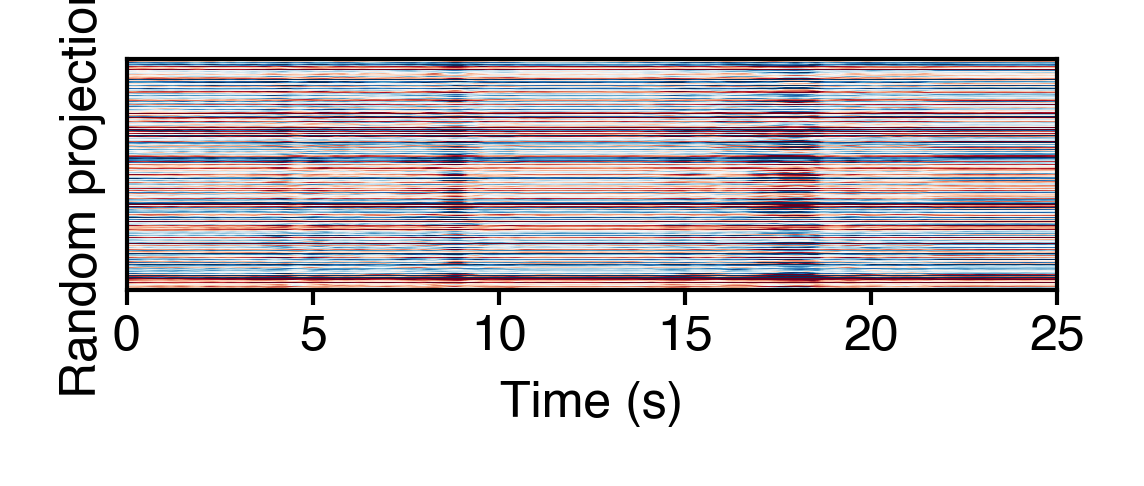

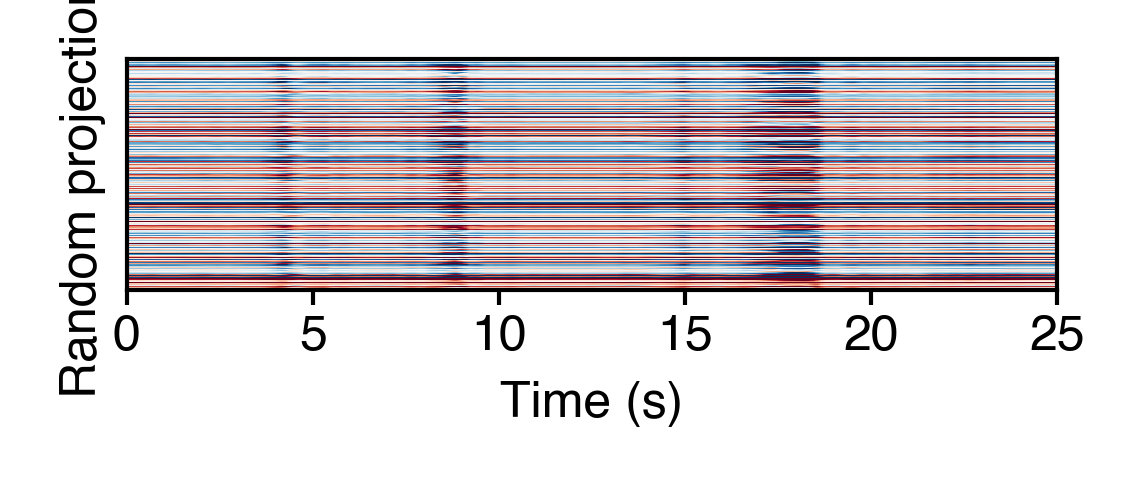

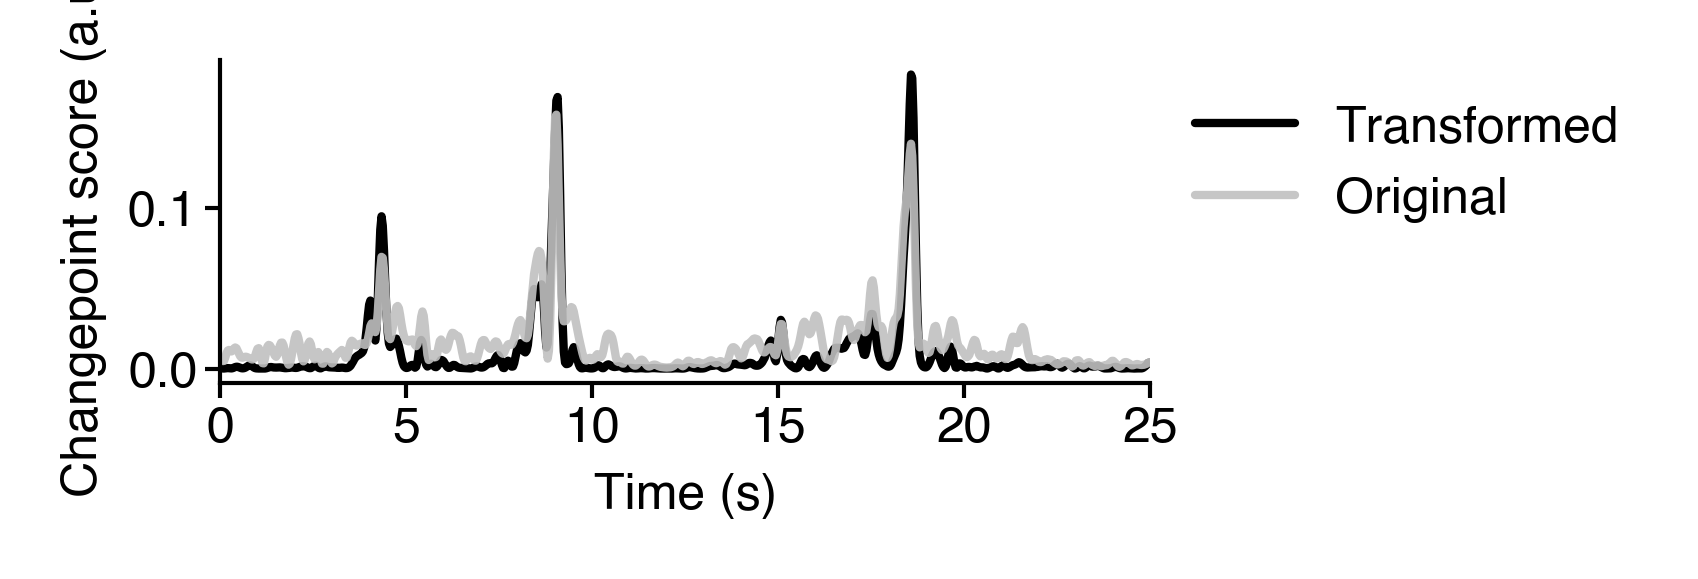

In [64]:
age = 68
session_idx = 1
frames = frames_dict[age][session_idx]
transformed_frames = recon_frames_dict[age][session_idx]

figs = plot_changepoints(
    frames, transformed_frames, start_idx=0, cmap=cmap, lims=lims
)
saver(figs[0], f'rps-{age}w-raw')
saver(figs[1], f'rps-{age}w-transformed')
saver(figs[2], f'cps-{age}w');

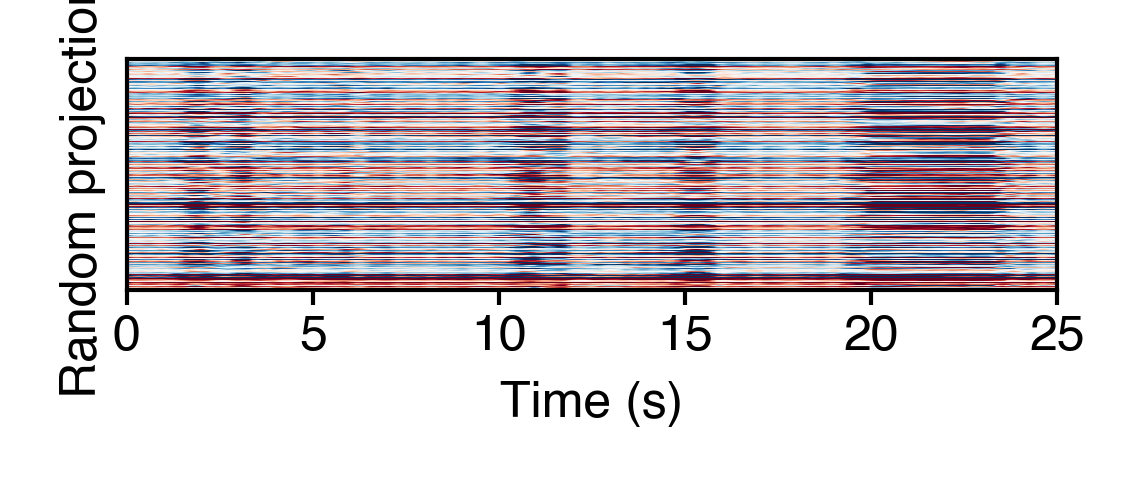

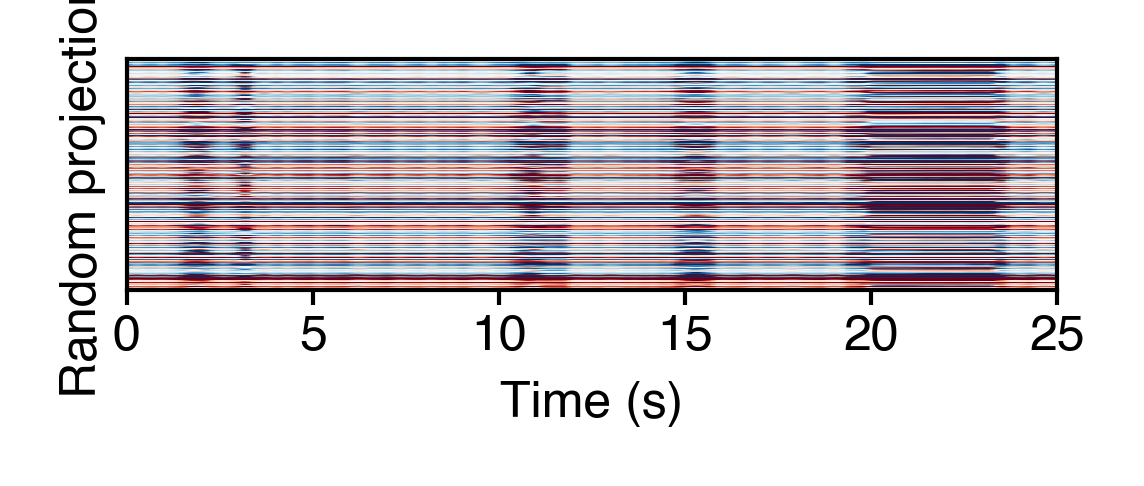

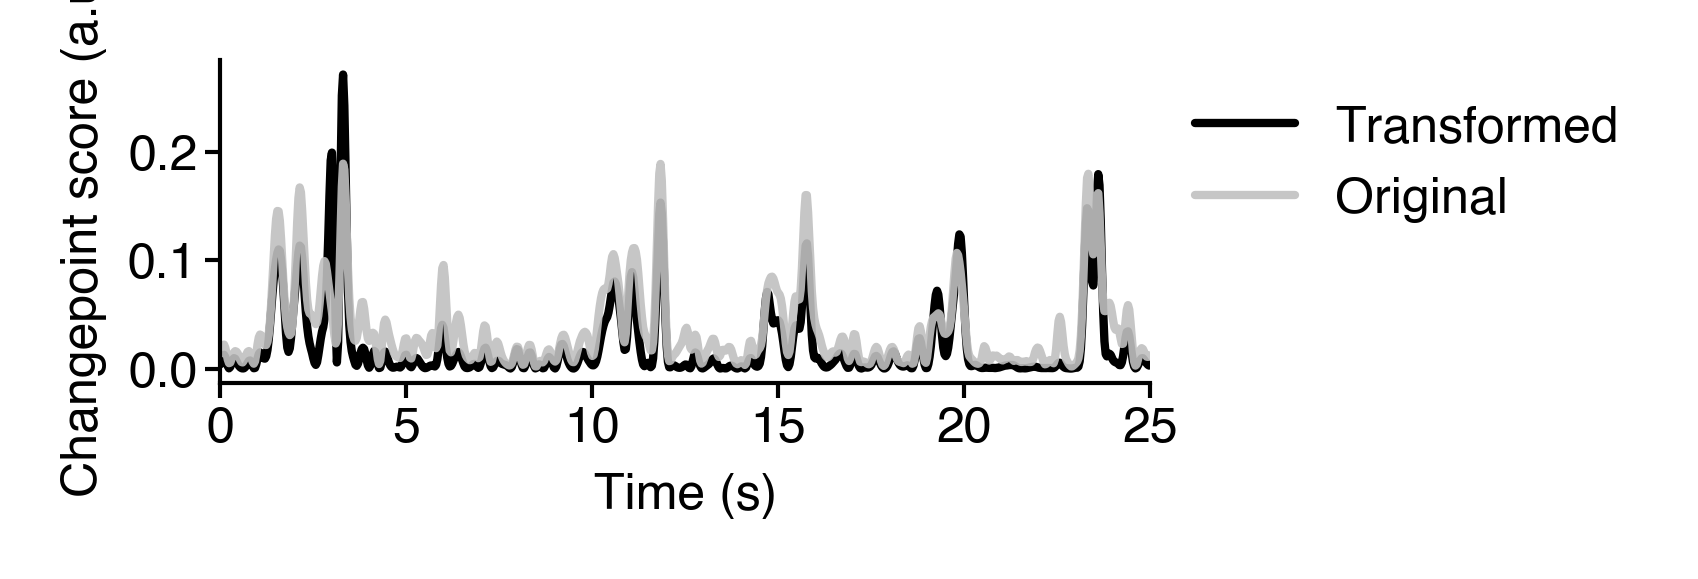

In [65]:
age = 4
session_idx = 1
frames = frames_dict[age][session_idx]
transformed_frames = recon_frames_dict[age][session_idx]

figs = plot_changepoints(
    frames, transformed_frames, start_idx=500, cmap=cmap, lims=lims
)
saver(figs[0], f'rps-{age}w-raw')
saver(figs[1], f'rps-{age}w-transformed')
saver(figs[2], f'cps-{age}w');

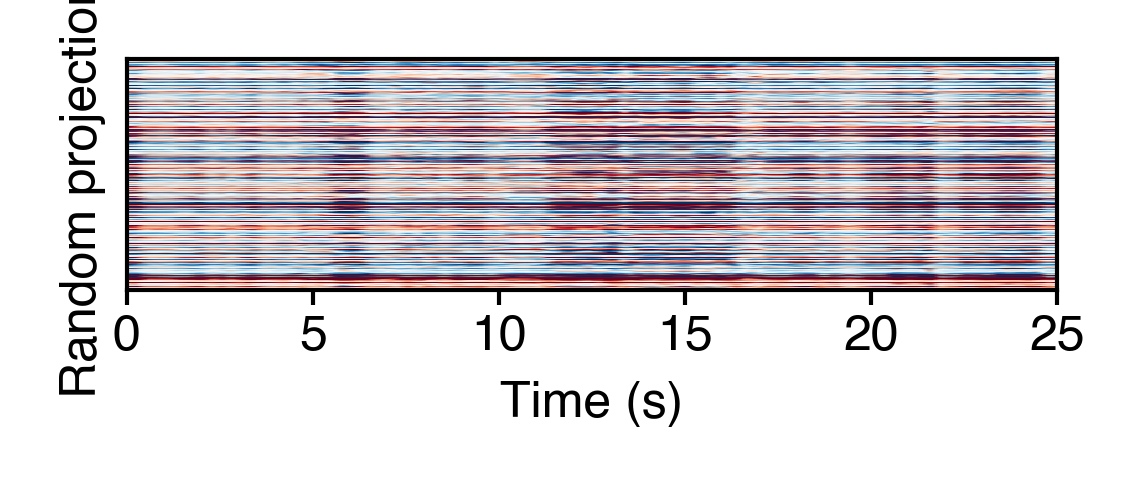

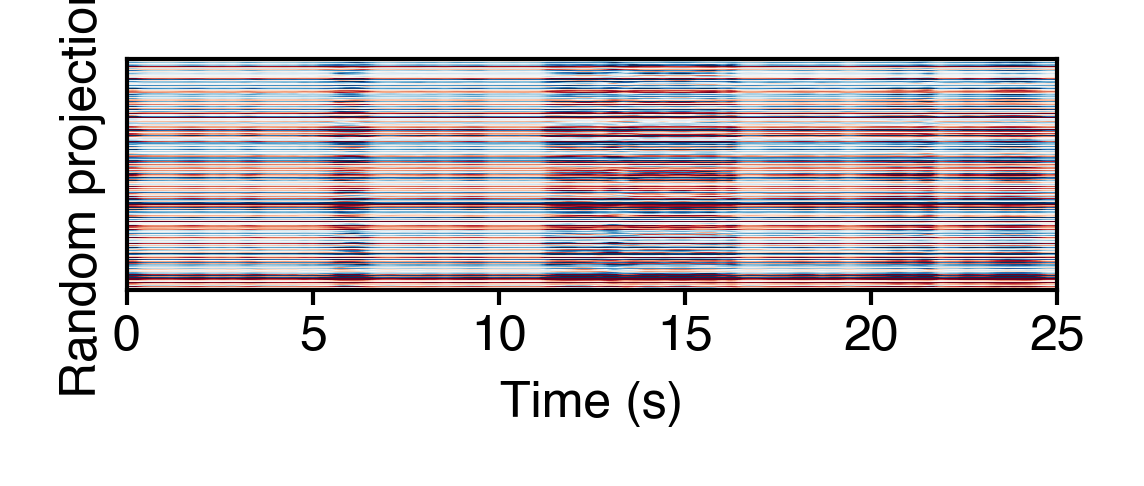

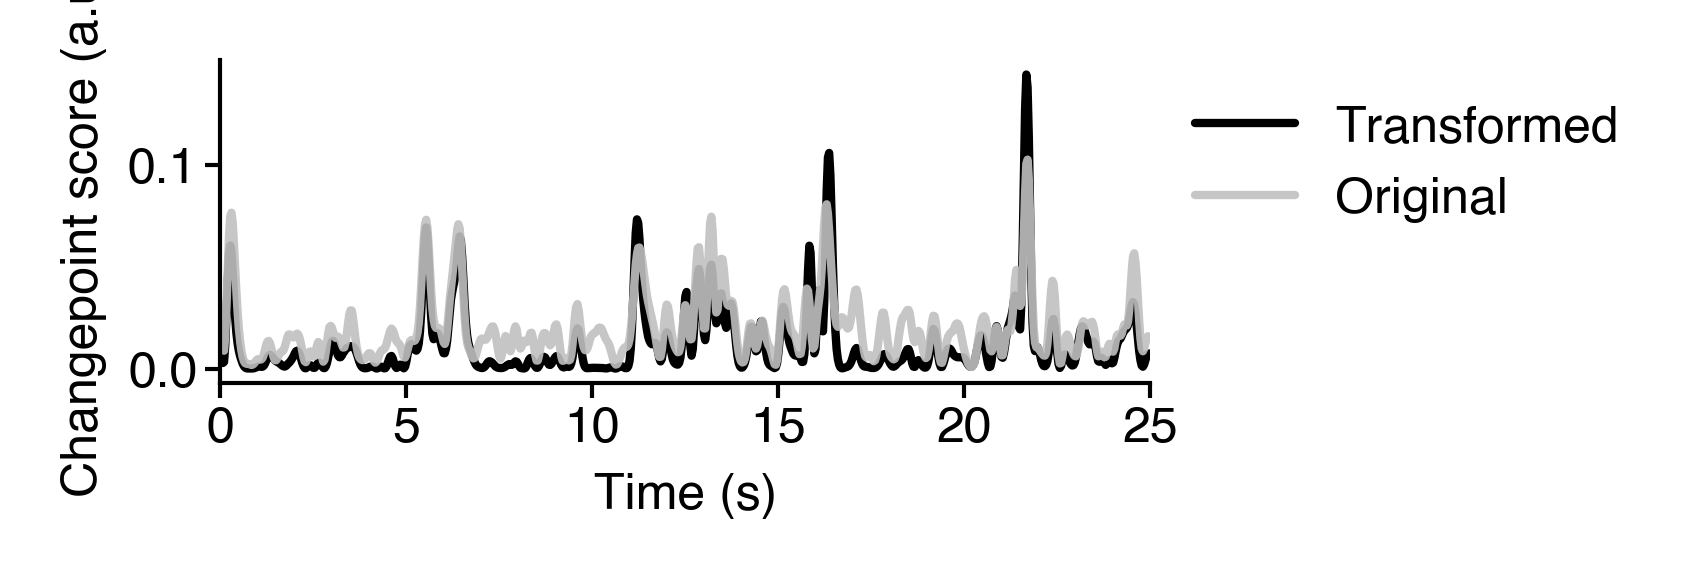

In [66]:
age = 12
session_idx = 1
frames = frames_dict[age][session_idx]
transformed_frames = recon_frames_dict[age][session_idx]

figs = plot_changepoints(
    frames, transformed_frames, start_idx=1000, cmap=cmap, lims=lims
)
saver(figs[0], f'rps-{age}w-raw')
saver(figs[1], f'rps-{age}w-transformed')
saver(figs[2], f'cps-{age}w');

### Compute changepoint correlations

In [67]:
from collections import defaultdict

In [68]:
cp_dict = defaultdict(list)
for k, v in tqdm(frames_dict.items()):
    for frames, recon_frames in zip(v, recon_frames_dict[k]):
        cp, _, mdl = compute_changepoints(frames)
        cp_t, _, _ = compute_changepoints(recon_frames, mdl=mdl)

        c = cp.corr(cp_t)
        cp_dict[k].append(c)

  0%|          | 0/17 [00:00<?, ?it/s]

In [69]:
cp_df = pd.concat((pd.DataFrame({"corr": d, "Age": k}) for k, d in cp_dict.items()), ignore_index=True)

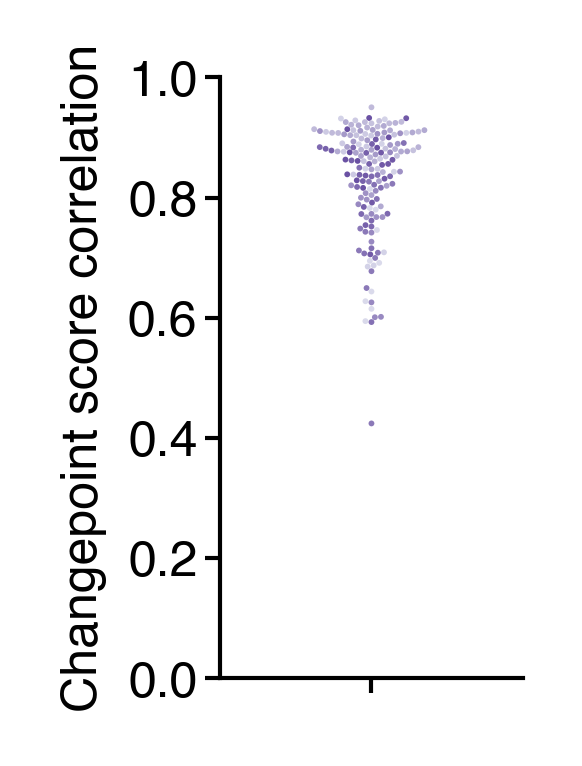

In [70]:
fig = figure(0.65, 1.3)
ax = sns.swarmplot(
    data=cp_df,
    y="corr",
    hue="Age",
    palette=female_cmap,
    size=0.7,
    legend=False,
)
ax.set(ylim=(0, 1), ylabel="Changepoint score correlation")
sns.despine()
saver(fig, "cps-correlation-vs-age-swarmplot");